In [3]:
# More readable tracebacks from the wonderful `rich` package
from rich.traceback import install
install(show_locals=True)

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f65e5e75af0>>

In [4]:
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Data processing
from nltk.corpus import stopwords

# Other
from tqdm import tqdm  # Progress bar
from IPython.display import display, Markdown  # For printing markdown formatted output

# Saving objects
We create some reuseable code for saving objects for later use, so we don't have to re-run time consuming code.

In [5]:
import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Read data 

In [6]:
tweet = pd.read_csv('./input/nlp-getting-started/train.csv')
test  = pd.read_csv('./input/nlp-getting-started/test.csv')

# Inspect data

### Size of the data

In [7]:
print(tweet.shape)
print(test.shape)

(7613, 5)
(3263, 4)


The training data rows contain a `keyword`, a `location` (sometimes not present), `text` containg a tweet and a `target` coding 1 for disaster and 0 for non-disaster.

The training data contains 7613 observations, while the test data contains 3263 observations.

In [8]:
tweet.iloc[200:203]

,id,keyword,location,text,target
200,281,ambulance,VISIT MY YOUTUBE CHANNEL.,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...,0
201,283,ambulance,Lexington,http://t.co/FueRk0gWui Twelve feared killed in...,1
202,285,ambulance,NaN,http://t.co/X5YEUYLT1X Twelve feared killed in...,1


At first glance location does not seem trustworthy.

By inspecting a few tweets we see that we need to clean the text before we can analyze it.

In [9]:
for i in [677, 2643, 3134, 92, 2290, 2062, 3681, 2343, 2384, 323]:
    # Print using markdown for better formatting
    tg = tweet.iloc[i]["target"]
    tw = tweet.iloc[i]["text"]
    display(Markdown(f"Target: {tg} -- {tw}"))

Target: 0 -- https://t.co/WKv8VqVkT6 #ArtisteOfTheWeekFact say #Conversations by #coast2coastdjs agree @Crystal_Blaz 's #Jiwonle is a #HipHop #ClubBanger

Target: 1 -- RSS: Russia begins mass destruction of illegally imported food   http://t.co/r6JDj9kIGm

Target: 1 -- Emergency Flow  http://t.co/lH9mrYpDrJ mp3 http://t.co/PqhuthSS3i rar http://t.co/0iW6dRf5X9

Target: 1 -- 8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY at 2781 WILLIS FOREMAN RD http://t.co/VCkIT6EDEv

Target: 0 -- Absurdly Ridiculous MenÛªs #Fashion To Demolish You #Manhood. http://t.co/vTP8i8QLEn

Target: 0 -- i miss my longer hair..but it was so dead anyways it wasn't even hair

Target: 0 -- @Babybackreeve FATALITY!!!!!!!!!!

Target: 1 -- Demolition Means Progress: Flint Michigan and the Fate of the American Metropolis Highsmith https://t.co/ZvoBMDxHGP

Target: 1 -- How do you derail a train at... Smithsonian?

Target: 0 -- @paddytomlinson1 ARMAGEDDON

We see that
- There are many unusual symbols, such as in "MenÛªs", and hashtags (#)
- We need to remove urls
- Many tweets have date tags, such as "8/6/2015@2:09 PM:"

## Keywords
The keyword column contain an important keyword present in the tweet, such as "sinking".

In [10]:
tweet[tweet['keyword']=='sinking'][["text", "target"]].head(10)

,text,target
6085,Do you feel like you are sinking in low self-i...,0
6086,After a Few Years Afloat Pension Plans Start S...,1
6087,Do you feel like you are sinking in unhappines...,0
6088,With a sinking music video tv career Brooke Ho...,0
6089,@supernovalester I feel so bad for them. I can...,0
6090,#nowplaying Sinking Fast - Now or Never on Nor...,0
6091,that horrible sinking feeling when youÛªve be...,1
6092,Nigga car sinking but he snapping it up for fo...,0
6093,@abandonedpics You should delete this one it's...,0
6094,that horrible sinking feeling when youÛªve be...,0


It looks like I found a contradiction in the dataset:

In [11]:
for i in [6091, 6094]:
    print("\n-Target: ",tweet.iloc[i].target)
    print("-Tweet: \n", tweet.iloc[i].text)


-Target:  1
-Tweet: 
 that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time

-Target:  0
-Tweet: 
 that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time


TODO: 
- Inspect if there are many of these
  - Find number of duplicate tweets

In [12]:
tweet.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

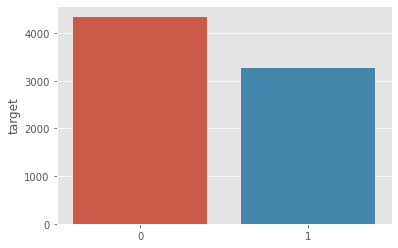

In [13]:
value_dist = tweet.target.value_counts()

sns.barplot(x=value_dist.index, y=value_dist)
plt.show()

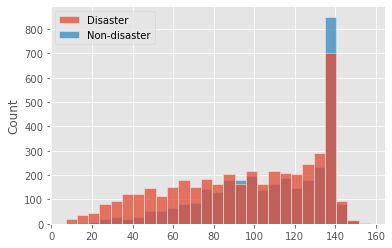

In [14]:
tw_len = tweet.text.str.len()

dta = {k:v for (k,v) in zip(["Disaster", "Non-disaster"], [tw_len[tweet.target==i] for i in [0,1]])}
sns.histplot(dta)
plt.show()

# Sentiment analysis
We will try adding a sentiment analysis score to our tweets. `SentimentIntensityAnalyzer` from `nltk` gives pieces of text a sentiment score between -1 and 1, where 1 is very positive and -1 is very negative

TODO: Add estimated sentiment to model input 

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

sia_table = []
for tweet_i in tweet['text']:
    sia_table.append(sia.polarity_scores(tweet_i)['compound'])

In [16]:
tweet['sentiment'] = sia_table

We inspect ten random tweets

In [17]:
print(f"Target | Sentiment | Tweet")
for i, row in tweet.iloc[[5585, 1708, 2297, 2759, 6229, 7439, 1766, 5314, 5725, 1582]].iterrows():
    print(f"{row.target:6} | {row.sentiment:9.4f} | {row.text}")

Target | Sentiment | Tweet
     1 |    0.0000 | http://t.co/iXiYBAp8Qa The Latest: More homes razed by Northern California wildfire - Lynchburg News and Advance http://t.co/zEpzQYDby4
     0 |    0.6636 | Reading for work has collided with reading for pleasure. Huzzah. Don't miss @molly_the_tanz's Vermilion! http://t.co/83bMprwH7W
     0 |    0.0000 | think i'll become a businessman a demolish a community centre and build condos on it but foiled by a troupe of multi-racial breakdancers .
     1 |   -0.8481 | 70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/LtVVPfLSg8
     0 |    0.0000 | 'Snowstorm' 36'x36' oil on canvas (2009) http://t.co/RCZAlRU05o #art #painting
     0 |    0.0000 | We would become the mirrors that reflected each other's most private wounds and desires.
     1 |   -0.6369 | #Colorado #News Motorcyclist bicyclist injured in Denver collision on Broadway: At least two people were tak... http://

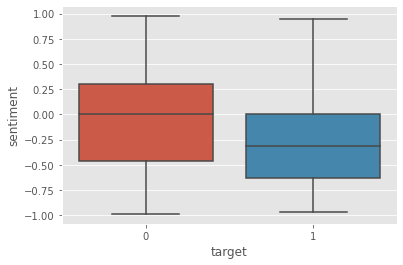

In [18]:
sns.boxplot(x=tweet.target, y=tweet.sentiment)
plt.show()

Sentiment of disaster tweets seem to fall slightly lower than non-disaster tweets on average. It might have stronger predictive quality together with high leverl features of the tweets discovered by the neural network. 

Sentiment does not seem to separate the two classes, but might be predictive in connection with higher level features detected by the neural network.
- TODO: How to implement sentiment in the analysis?

# Ngram analysis
- Uninformative
- From https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Exploratory-Data-Analysis-of-tweets

In [19]:
def get_top_tweet_bigrams(corpus, n=None):
    from sklearn.feature_extraction.text import CountVectorizer
    
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Word embedding vectorization
We will vectorize words using a library of vectors from a pre trained model.

- TODO: Fine tune on current dataset
  - see demo.sh in the github repo
- Alternative dataset: https://allennlp.org/elmo


We will use GloVe for vectorization of words found at https://github.com/stanfordnlp/GloVe,
trying the twitter dataset first.

In [20]:
# import mmap

def get_num_lines(file_path: str):
    """
    Get the number of lines in a file. 
    Used in the tqdm module to get a progress bar for 
    for-loops when iterating over lines in a file.
    """
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

In [21]:
# # Run this once to save an embedding dictionary to a file in and obj/ folder in current dir (`obj` dir must be created beforehand)

# embedding_dict={}
# file_path = './input/glove.twitter.27B.100d.txt'
# with open(file_path,'r') as f:
#     for line in tqdm(f, total = get_num_lines(file_path)):
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embedding_dict[word]=vectors
# f.close()

# save_obj(embedding_dict, "embedding_dict")

In [22]:
# Load saved embedding dictionary from previous cell
embedding_dict = load_obj("embedding_dict")

- TODO: Visualize embeddings with PCA?

# Clean tweets

We will need to preprocess the data based on how words are embedded into the pre-trained embeddings.

We will first attempt some boiler-plate text cleaning, courtesy of among others [this notebook](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#GloVe-for-Vectorization), and inspect how well it coincides with the embedding.

## Inital cleaning attempt 

In [23]:
tweet.text.iloc[3639]

'Mortal Kombat X: All Fatalities On Meat Predator.\nhttps://t.co/IggFNBIxt5'

In [24]:
def clean_data(df: pd.DataFrame):
    import string
    import re

    punctuation_regex = re.compile(f"[{re.escape(string.punctuation)}:]")
    emoji_pattern = re.compile("["
                               "\U0001F600-\U0001F64F"  # emoticons
                               "\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "\U0001F680-\U0001F6FF"  # transport & map symbols
                               "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "\U00002702-\U000027B0"  # Symbols
                               "\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Clean training data
    df.keyword.str.replace("%20", " ")  # We replace ascii %20 with space in the keywords, e.g 'body%20bags' -> 'body bags'
    df.text = df.text.str.lower()
    df.text = df.text.str.replace(r"https[^\s|$]*", "", regex=True)  # Change all urls to "URL"
    df.text = df.text.str.replace(punctuation_regex, "", regex=True)
    df.text = df.text.str.replace(emoji_pattern, "", regex=True)  # Remove emojis and symbols
    df.text = df.text.str.replace(r"\n", " ", regex = True)       # Change \n to space
    df.text = df.text.str.replace(r"[^a-zA-Z0-9 ]", "", regex=True)  # Remove last non word characters
    df.text = df.text.str.replace(r"<.*?>", "", regex=True)  # Remove html tags (e.g. <div> )

    return df

In [25]:
cleaned_tweet = clean_data(tweet)

In [26]:
cleaned_tweet.text.iloc[3639]

'mortal kombat x all fatalities on meat predator '

### Check embedding coverage

We check how many of the words in our training set tweets are covered by the embedding dictionary

In [27]:
def word_representation(word_dict: dict , word_list: list):
    """Return the words from uq_words not contained in word_dict 
    and the number of words not covered."""
    n_covered = 0
    not_covered = []
    for word in word_list:
        if word in word_dict:
            n_covered += 1
        else:
            not_covered.append(word)

    return n_covered, not_covered

In [28]:
def get_unused_words(word_dict: dict , word_list: list):
    """Returns a list of words from word_dict not contained in word_list"""
    unused_words = word_dict.copy()#.keys())

    # Remove words in tweet data from the dict
    for word in word_list:
        try:
            unused_words.pop(word)
        except KeyError:
            pass

    #Convert dict to list
    return list(unused_words.keys())

In [29]:
uq_words = tweet.text.str.split(expand=True).stack().unique()
n_covered, not_covered = word_representation(word_dict = embedding_dict, word_list = uq_words)
unused_words = get_unused_words(word_dict = embedding_dict, word_list = uq_words)

- Emojis have an embedding and might encode and important meaning in the tweets
- There seems to be <user>, <hashtag>, <url> and <number> placeholders

Checking the coverage of the tweets, we see that only 56% of the words in our data are in the embedding dictionary.

In [30]:
n_covered/len(uq_words)

0.5676696863477034

While only 1% of the words in the embedding dictionary is used.

In [31]:
n_covered/len(embedding_dict)

0.01044813010309883

This calls for further inquiry. Checking the words not covered by the embeddings, we see that there are numbers, URL's and  words with repeated number of letters (elongated words) eg. 'goooooooaaaaaal' among other things.

In [32]:
",  ".join(not_covered[0:20])

'13000,  rockyfire,  20,  cafire,  18,  19,  80,  goooooooaaaaaal,  bbcmtd,  httptcolhyxeohy6c,  httptcoyao1e0xngw,  africanbaze,  newsnigeria,  httptco2nndbgwyei,  httptcoqqsmshaj3n,  phdsquares,  httptco3imaomknna,  superintende,  httptcowdueaj8q4j,  httptcoroi2nsmejj'

When inspecting some of the unused words in the embedding dictionary we see that many things, such as hashtags, repeated letters in words, allcaps words and smileys are encoded with special placeholders, such as <allcaps>

In [33]:
"  ".join(unused_words[0:100])

'<user>  .  :  ,  <repeat>  <hashtag>  <number>  <url>  !  "  ?  (  <allcaps>  <elong>  )  <smile>  ！  。  -  、  …  /  \'s  *  n\'t  \'  \'m  >  ^  ？  <  ・  &  ♥  lo  “  ”  por  _  <sadface>  من  ♡  ´  ،  ~  ;  <heart>  aku  \'re  <lolface>  una  （  >>  في  ･  le  é  |  [  ）  ]  yg  —  笑  ω  je  yang  ❤  não  ～  ★  `  dia  $  و  الله  pero  ♪  \'ll  =  nn  ｀  ¿  <neutralface>  لا  +  ada  ☆  ni  \'ve  itu  على  -_-  ☺  ما  todo  mais  ini  ﾟ  aja'

## Cleaning and pre-processing for the GloVe embedding
In their [info page](https://nlp.stanford.edu/projects/glove/) the writers of the GloVe algorithm supply a ruby regex used for text pre-processing for the twitter model.

In an [issue thread](https://github.com/stanfordnlp/GloVe/issues/107) discussing text pre-processing for tweets on their Github page user [skondrashov](https://github.co/skondrashov) supplies a useful python conversion of this ruby script, that also illustrates how words are adjusted to fit in a standard dictionary, and tagged for special characters or rewritings, such as being prefixed with a hashtag or elongated.

## Remove contractions
Copied from https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/, with a small tweak for not matching `'s` in words surrounded by single quotation mark, like `'sylvester stallone'`.

In [35]:
import re

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "i'd": "i would", "i'd've": "i would have","i'll": "i will",
                     "i'll've": "i will have","i'm": "i am","i've": "i have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
#    adding positive lookbehind for `'s` in the regex to make sure a letter is preceeding
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()).lower().replace("|'s", "|(?<=[a-zA-Z])'s"))
contractions_re

re.compile(r"(ain't|(?<=[a-zA-Z])'s|aren't|can't|can't've|'cause|could've|couldn't|couldn't've|didn't|doesn't|don't|hadn't|hadn't've|hasn't|haven't|he'd|he'd've|he'll|he'll've|how'd|how'd'y|how'll|i'd|i'd've|i'll|i'll've|i'm|i've|isn't|it'd|it'd've|it'll|it'll've|let's|ma'am|mayn't|might've|mightn't|mightn't've|must've|mustn't|mustn't've|needn't|needn't've|o'clock|oughtn't|oughtn't've|shan't|sha'n't|shan't've|she'd|she'd've|she'll|she'll've|should've|shouldn't|shouldn't've|so've|that'd|that'd've|there'd|there'd've|they'd|they'd've|they'll|they'll've|they're|they've|to've|wasn't|we'd|we'd've|we'll|we'll've|we're|we've|weren't|what'll|what'll've|what're|what've|when've|where'd|where've|who'll|who'll've|who've|why've|will've|won't|won't've|would've|wouldn't|wouldn't've|y'all|y'all'd|y'all'd've|y'all're|y'all've|you'd|you'd've|you'll|you'll've|you're|you've)",
re.UNICODE)

In [36]:
tweet= pd.read_csv('./input/nlp-getting-started/train.csv')
test=pd.read_csv('./input/nlp-getting-started/test.csv')

In [37]:
# Function for expanding contractions
# def expand_contractions(text, contractions_dict=contractions_dict):
#     for match in contractions_re.findall(text):
#     return contractions_re.sub(replace, text)
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(1)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df = tweet.copy()
df.loc[:, 'text']=df.loc[:, 'text'].apply(expand_contractions)

In [38]:
# Print the ten first edited tweets

i = 0
j = 0
while j < 10:
    a = tweet.loc[i,'text']
    b = df.loc[i,'text']
    if (len(a) != len(b)):
        print(a)
        print(b)
        j += 1
    i += 1

There's an emergency evacuation happening now in the building across the street
There is an emergency evacuation happening now in the building across the street
What's up man?
What is up man?
No way...I can't eat that shit
No way...I cannot eat that shit
@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.
@PhDSquares #mufc they have built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.
on the outside you're ablaze and alive
but you're dead inside
on the outside you are ablaze and alive
but you are dead inside
First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.
First night with retainers in. It is quite weird. Better get used to it; I have to wear them every single night for the next year at least.
@ablaze what time does your talk go until? I don't know if I can make it due to work.
@ablaz

### Implementing a cleaning function for repeated letters

In [39]:
# TODO: 

import re


word = "goooaaaallls"  # We want to match go[oo]a[aaa]l[ll]s

# Get list of matches: [(group1, group2, ...), ...] where match group 3 is the repeated letters
m = re.findall(r"(\S*?)(\w)(\2{1,})(\S*?)", word)
m

[('g', 'o', 'oo', ''), ('', 'a', 'aaa', ''), ('', 'l', 'll', '')]

In [40]:
repeated_letters = [match[2] for match in m]
repeated_letters

['oo', 'aaa', 'll']

In [41]:
from itertools import combinations

# Loop over all combinations of repeated letters
print(f"{'Cleaned word':12s} - Removed letters")
print("=============================")
for i in range(len(repeated_letters), 0, -1):
    for combination in combinations(repeated_letters, r=i+1):
        tword = word
        for letters in combination:
            tword = re.sub(letters, "", tword)
        print(f"{tword:14s}{combination}")

Cleaned word - Removed letters
goals         ('oo', 'aaa', 'll')
goallls       ('oo', 'aaa')
goaaaals      ('oo', 'll')
goooals       ('aaa', 'll')


### Cleaning function for tweets

In [42]:
from itertools import combinations

def clean_tweets(df):
    import re

    def sub(pattern, output, string, whole_word=False):
        token = output
        if whole_word:
            pattern = r'(\s|^)' + pattern + r'(\s|$)'

        if isinstance(output, str):
            token = ' ' + output + ' '
        else:
            token = lambda match: ' ' + output(match) + ' '

        return re.sub(pattern, token, string)


    def hashtag(token):
        """ Replace hashtag `#` with `<hashtag>` and split following joined words."""
        token = token.group('tag')
        if token != token.upper():
            token = ' '.join(re.findall('[a-zA-Z][^A-Z]*', token))

        return '<hashtag> ' + token

    def punc_repeat(token):
        return token.group(0)[0] + " <repeat>"

    def punc_separate(token):
        return token.group()

    def number(token):
        return token.group() + ' <number>';

    def word_end_repeat(token):
        return token.group(1) + token.group(2) + ' <elong>'
    
    def allcaps(token):
        return token.group() + ' <allcaps>'

    def clean_repeated_letters(tweet: str, embedding_dict: dict):
        """
        Splits a tweet into words, finds repeated letters in the word and
        removes combinations of the repeated letters until the word is matched by a key in
        embedding_dict
        """

        cleaned_tweet = []

        for word_i in tweet.split():
            word_found = False
            if word_i in embedding_dict:
                cleaned_tweet.append(word_i)
                continue

            matches = re.findall(r"""(\S*?)    # 1: Optional preceeding letters
                                     (\w)      # 2: A letter that might be repeated
                                     (\2{1,})  # 3: Repetead instances of the preceeding letter (group 2)
                                     (\S*?)    # 4: Optional trailing letters""",
                                 word_i,
                                 flags=re.X)  # Verbose regex, for commenting
                                 
            repeated_letters = [match[2] for match in matches]
                    
            # Loop over all combinations of repeated letters
            for i in range(len(repeated_letters), 0, -1):  # i decides length of combination
                if word_found:
                    continue
                    
                for combination in combinations(repeated_letters, r = i):
                    if word_found:
                        continue
                        
                    tword = word_i 
                    
                        
                    for letters in combination:
                        tword = re.sub(letters, "", tword, count=1)
                                        
                        # Word in the embedding dict?
                        if (tword in embedding_dict):
                            # Keep the word and stop searching
                            word_found = True
                            tword = tword + " <elong>"
                            continue  
            if not word_found:
                # No match, we simply keep the word
                tword = word_i
                
            cleaned_tweet.append(tword)
            
        return " ".join(cleaned_tweet)



    eyes        = r"[8:=;]"
    nose        = r"['`\-\^]?"
    sad_front   = r"[(\[/\\]+"
    sad_back    = r"[)\]/\\]+"
    smile_front = r"[)\]]+"
    smile_back  = r"[(\[]+"
    lol_front   = r"[DbpP]+"
    lol_back    = r"[d]+"
    neutral     = r"[|]+"
    sadface     = eyes + nose + sad_front   + '|' + sad_back   + nose + eyes
    smile       = eyes + nose + smile_front + '|' + smile_back + nose + eyes
    lolface     = eyes + nose + lol_front   + '|' + lol_back   + nose + eyes
    neutralface = eyes + nose + neutral     + '|' + neutral    + nose + eyes
    punctuation = r"""[ '!"#$%&'()+,/:;=?@_`{|}~\*\-\.\^\\\[\]]+""" ## < and > omitted to avoid messing up tokens

    for i in range(df.shape[0]):
        df.loc[i,'text'] = sub(r'[\s]+',                             '  ',            df.loc[i,'text']) # ensure 2 spaces between everything
        df.loc[i,'text'] = sub(r'(?:(?:https?|ftp)://|www\.)[^\s]+', '<url>',         df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(r'@\w+',                              '<user>',        df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(r'#(?P<tag>\w+)',                     hashtag,         df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(sadface,                              '<sadface>',     df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(smile,                                '<smile>',       df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(lolface,                              '<lolface>',     df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(neutralface,                          '<neutralface>', df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(r'(?:<3+)+',                          '<heart>',       df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(r'\b[A-Z]+\b',                         allcaps,       df.loc[i,'text'], True) 
        # Allcaps tag
        df.loc[i,'text'] = df.loc[i,'text'].lower()
        df.loc[i,'text'] = expand_contractions(df.loc[i, 'text'])
        df.loc[i,'text'] = sub(r'[-+]?[.\d]*[\d]+[:,.\d]*',          number,          df.loc[i,'text'], True)
        df.loc[i,'text'] = sub(punctuation,                          punc_separate,   df.loc[i,'text'])
        df.loc[i,'text'] = sub(r'([!?.])\1+',                        punc_repeat,     df.loc[i,'text'])
#     df.loc[i,'text'] = sub(r'(\S*?)(\w)\2+\b',                   word_end_repeat, df.loc[i,'text'])
        
        df.loc[i,'text'] = clean_repeated_letters(df.loc[i,'text'], embedding_dict)
#     tweet = sub(r"(\S*?)(\w)(\2{1,})(\S*?)",          word_repeat,     tweet)
#     tweet = sub(r'(\S*?)(\w*(\w)\2+\w*)\2+\b',                   word_repeat, tweet)
    return df

In [46]:
temp = pd.DataFrame({"text": [
    u"I'm hoping they're helping, they've got to",
    u'goooooooaaaaaallll, hey its a goall gooal',
    u'http://foo.com/blah_blah http://foo.com/blah_blah/ http://foo.com/blah_blah_(wikipedia) https://foo_bar.example.com/',
    u':\\ :-/ =-( =`( )\'8 ]^; -.- :/',
    u':) :-] =`) (\'8 ;`)',
    u':D :-D =`b d\'8 ;`P',
    u':| 8|',
    u'<3<3 <3 <3',
    u'#swag #swa00-= #as ## #WOOP #Feeling_Blessed #helloWorld',
    u'holy crap!! i won!!!!@@!!!',
    u'holy *IUYT$)(crap!! @@#i@%#@ swag.lord **won!!!!@@!!! wahoo....!!!??!??? Im sick lol.',
    u'this SENTENCE consisTS OF slAyYyyy slayyyyyy #WEIRD caPITalIZAtionn',
    ]})
temp_uncleaned = temp.copy()
clean_tweets(df = temp)

for i in range(temp.shape[0]):
#     print("====================")
    print("Original: ", temp_uncleaned.iloc[i].text)
    print("Cleaned:  ", temp.iloc[i].text)

Original:  I'm hoping they're helping, they've got to
Cleaned:   i am hoping they are helping , they have got to
Original:  goooooooaaaaaallll, hey its a goall gooal
Cleaned:   goal <elong> , hey its a goall gooal
Original:  http://foo.com/blah_blah http://foo.com/blah_blah/ http://foo.com/blah_blah_(wikipedia) https://foo_bar.example.com/
Cleaned:   <url> <url> <url> <url>
Original:  :\ :-/ =-( =`( )'8 ]^; -.- :/
Cleaned:   <sadface> <sadface> <sadface> <sadface> <sadface> <sadface> -.- <sadface>
Original:  :) :-] =`) ('8 ;`)
Cleaned:   <smile> <smile> <smile> <smile> <smile>
Original:  :D :-D =`b d'8 ;`P
Cleaned:   <lolface> <lolface> <lolface> <lolface> <lolface>
Original:  :| 8|
Cleaned:   <neutralface> <neutralface>
Original:  <3<3 <3 <3
Cleaned:   <heart> <heart> <heart>
Original:  #swag #swa00-= #as ## #WOOP #Feeling_Blessed #helloWorld
Cleaned:   <hashtag> swag # swa00 -= <hashtag> as ## <hashtag> woop <allcaps> <hashtag> feeling _ blessed <hashtag> hello world
Original:  holy 

Because `goall` and `gooal` is in the GloVe embedding dictionary, they are not shortened to `goal`.

As they 

### Cleaning and checking embedding coverage

In [101]:
tweet= pd.read_csv('./input/nlp-getting-started/train.csv')
test=pd.read_csv('./input/nlp-getting-started/test.csv')

In [102]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [103]:
clean_tweets(tweet)

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this <hashtag> ear...,1
1,4,NaN,NaN,forest fire near la ronge sask . canada,1
2,5,NaN,NaN,all residents asked to ' shelter in place ' ar...,1
3,6,NaN,NaN,"13 , 000 <number> people receive <hashtag> wil...",1
4,7,NaN,NaN,just got sent this photo from ruby <hashtag> a...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,<user> <user> the out of control wild fires in...,1
7610,10871,NaN,NaN,m1 . 94 [ 01 : 04 utc ]? 5km s <allcaps> of vo...,1
7611,10872,NaN,NaN,police investigating after an e - bike collide...,1


In [112]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this <hashtag> ear...,1
1,4,NaN,NaN,forest fire near la ronge sask . canada,1
2,5,NaN,NaN,all residents asked to ' shelter in place ' ar...,1
3,6,NaN,NaN,"13 , 000 <number> people receive <hashtag> wil...",1
4,7,NaN,NaN,just got sent this photo from ruby <hashtag> a...,1


In [105]:
uq_words = tweet.text.str.split(expand=True).stack().unique()
n_covered, not_covered = word_representation(word_dict = embedding_dict, word_list = uq_words)
unused_words = get_unused_words(word_dict = embedding_dict, word_list = uq_words)

Now 82% of the words in our data are in the embedding dictionary.

In [106]:
n_covered/len(uq_words)

0.8232293505983912

Still only 1% of the words in the embedding dictionary is used.

In [107]:
n_covered/len(embedding_dict)

0.01054699773358525

The words not covered by the embedding dictionary seem to be joined words such as `myreligion` many uncommon symbols and words and numbers. Hopefully these do not carry much meaning, and as they are uncommon it will be hard for our model to descipher their meaning.

In [108]:
# Words  in our data not in the embedding dictionary
"  ".join(not_covered[0:500])

"13  000  20  18  19  80  africanbaze  \x89ûò  \x89ûó  superintende  ancop  3  lanford  carolinaåêablaze  '@  diyala  r21  voortrekker  \x89û  gtxrwm  2k13  30  2013  tinderbox  24  nashvilletraffic  8m  101  personalinjury  caraccidentlawyer  tee\x89û  bigrigradio  77  31  6  1  sleepjunkies  08  06  15  11  03  58  40  ?'  ://  ld0uniyw4k  23  752  540  999  horndale  naayf  chandanee  conf\x89û  293  3a  4  1600  17th  2015  2  09  2781  suffield  9  langtree  115  150  16  5  your4state  marinading  .@  norwaymfa  arrestpastornganga  .'  320  icemoon  ices\x89û  xb1  wiedemer  \x89ã¢  2010  full\x89ã¢  ;&  wdyouth  ps4  8015  29  07  wednesday\x89û  t48  mbataweel  freaky\x89û  airplaneåê  ladins  \x89ûïairplane\x89û\x9d  can\x89ûªt  g90  12  emsne\x89û  yugvani  14  ems1  17  \x89û÷minimum  wage\x89ûª  \x89ûï  leoblakecarter  hatzolah  and\x89û  freiza  petebests  dessicated  eovm  h\x89û  70  100000  1960s  !'  zrnf  2005  fantasticfour  /#  fant4stic  \x89û÷alloosh  quarterstaff

Unused words from the embedding dictionary are mainly symbols and foreign words. Which means we seem to have captured most of the important meaning-bearing words.

In [109]:
# Unused words in the embedding dictionary
"  ".join(unused_words[0:500])

'"  ！  。  、  …  \'s  n\'t  \'m  ？  <  ・  ♥  “  ”  por  من  ♡  ´  ،  <heart>  aku  \'re  una  （  >>  في  ･  le  é  ）  yg  —  笑  ω  je  yang  ❤  não  ～  ★  dia  و  الله  pero  ♪  \'ll  nn  ｀  ¿  لا  ada  ☆  ni  \'ve  على  ☺  ما  todo  mais  ini  ﾟ  aja  ▽  apa  cuando  ✔  ؟  •  quiero  kamu  nada  <<  ta  lagi  █  más  mau  ｡  pas  в  hoy  meu  gak  amor  \\  ver  ；  porque  اللهم  gue  uma  vou  bien  ¡  ＾  ／  todos  →  kan  kita  jajaja  você  nos  tengo  ∀  كل  bisa  iya  eso  gente  udah  ：  ＼  mejor  minha  ti  voy  tapi  nunca  il  nya  orang  °  اللي  tem  soy  este  kalo  só  \'d  gracias  lah  и  ←  ⌣  estoy  tau  buat  я  kau  siempre  juga  casa  أن  feliz  bir  ahora  jadi  ka  vc  mundo  на  aqui  не  رتويت  يا  muy  mañana  mis  qué  mal  عن  día  dari  à  tiene  algo  ولا  c\'est  hari  jajajaja  jaja  dah  ░  eres  está  nih  nak  hace  vamos  فولو  vez  dos  bueno  nao  dormir  quien  untuk  jangan  gua  д  wkwk  saya  mucho  ’s  baru  hacer  des  kok  j\'  ان  cosas  xx

In [ ]:
tweet.text[tweet.text.str.match(r".*jonvoyage")]

# Spell correction

In [ ]:
!pip install pyspellchecker
# !conda install -c conda-forge pyspellchecker

In [ ]:
from spellchecker import SpellChecker

In [ ]:
spell = SpellChecker()

misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

Seems to work nicely.

Implementation copied from https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

- TODO implement into the data cleaning

# Preparing the data
We need to convert the text to sequences as input to the model

## Corpus
We first create a corpus, removing stop words
- TODO: Try keeping stopwords

In [ ]:
def create_corpus(text: pd.core.series.Series):
    """
    Creates a corpus while filtering out stop words and non-alphanumeric words
    """
    
    from nltk.tokenize import word_tokenize  # Tokenize words
    
    stop=set(stopwords.words('english'))
    corpus = []
    for tw in tqdm(text):   # For loop with progress bar
        words = [word for word in word_tokenize(tw) if ((word.isalpha()) & (not word in stop))]
        corpus.append(words)
    return corpus

We create a corpus from the training and test dataset. We will later split the data back into training and test data using the correct index.

In [ ]:
# We create a corpus from the training and test dataset. We will later split the data back into training and test data using the correct index.
corpus = create_corpus(tweet.text.append(test.text))
save_obj(corpus, "corpus")

In [ ]:
corpus = load_obj("corpus")

## Tokenization
We tokenize the tweets using helper functions from `keras`

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer_object = Tokenizer()

# Tokenize the words in the corpus
tokenizer_object.fit_on_texts(corpus)

# Create sequences from the text in the corpus. The words are now coded to numbers.
sequences = tokenizer_object.texts_to_sequences(corpus)

# We pad the tweets so that the model has input of equal length. Padding the start of text sequences seems to be the most widely used.
MAX_LEN = 50
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='pre', padding='pre')

# Save the tokenizer object
save_obj(tokenizer_object, "tokenizer_object")
save_obj(tweet_pad, "tweet_pad")

# Load previously created tokenizer
tokenizer_object = load_obj("tokenizer_object")
tweet_pad = load_obj("tweet_pad")

## Create embedding matrix
We create the embedding matrix, where each row is a pre-trained word embedding vector from the GloVe dictionary, and where row index coincides with the word token.


- TODO:For the index in the matrix to match the word tokens the embedding_matrix is padded with an initial row of zeros because tokenization starts at 1, while python list index starts at 0

In [ ]:
word_index = tokenizer_object.word_index
num_words = len(word_index) + 1

# embedding_matrix = np.zeros((num_words, 100))

# for word,i in tqdm(word_index.items(), total = len(word_index.items())):
#     emb_vec=embedding_dict.get(word)
#     if emb_vec is not None:
#         embedding_matrix[i,:]=emb_vec

# save_obj(embedding_matrix, "embedding_matrix")

embedding_matrix = load_obj("embedding_matrix")

## Initialize embedding layer
The embedding layer is a flexible layer that can be used in a variety of ways:
- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.


In [ ]:
from keras.layers import Embedding
from keras.initializers import Constant

embedding = Embedding(input_dim  = num_words,
                      output_dim = 100,
                      embeddings_initializer = Constant(embedding_matrix),
                      input_length = MAX_LEN,
                      mask_zero = True,  # Boolean, whether or not the input value 0 is a special "padding" value that should be masked out.
                     )

# Model creation
We now create our model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, SpatialDropout1D

## Building the model
We then set up our model
- TODO: What type of dropout to apply? (see discussion here https://github.com/keras-team/keras/issues/7290)

In [ ]:
model = Sequential()
model.add(embedding)
model.add(SpatialDropout1D(0.8))  # Dropout to reduce overfitting.
model.add(LSTM(64,
               dropout=0.25,  # Fraction of the units to drop for the linear transformation of the inputs.
               recurrent_dropout=0.25  # Fraction of the units to drop for the linear transformation of the recurrent state.
              ))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.summary()

## Split into training and test set
We split the training data into a training and test set for model optimization.
We choose test set size to be 15 % of the data, the remaining 85 % is used for training.

In [ ]:
from sklearn.model_selection import train_test_split

#We split our data sequences back into the original training and test data.
train_data = tweet_pad[:7613, :]
test_data = tweet_pad[7613:, :]

# We split the training data into a training and test set for the model fitting
x_train, x_val, y_train, y_val = train_test_split(train_data,
                                                    tweet['target'].values,
                                                    test_size=0.15)
print('Shape of train',x_train.shape)
print("Shape of Validation ",x_val.shape)

# Training the model

In [ ]:
# %%time

history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=9,
                    validation_data=(x_val, y_val),
                    verbose=2)

# Save the fitted model to a file
model.save('./obj/')

The model seems to overfit the data.

In [ ]:
# Loading the fitted model from file:

from tensorflow import keras
model = keras.models.load_model('./obj/')

In [ ]:
axes = sns.lineplot(data=pd.DataFrame(history.history)[["accuracy", "loss"]])

In [ ]:
axes = sns.lineplot(data=pd.DataFrame(history.history)[["val_accuracy", "val_loss"]])

Accuracy and loss seem to decrease on the validation set. This does not bode well.

## TODO
- Inspect misclassified tweets
- Compare to pretrained CNN
- Try larger word embedding
- Experiment with dropout

## Misclassified tweets

In [63]:
predictions = model.predict(test_data)

# TODO
- Remove non words
- encode urls?
- Encode complexity of text: https://pypi.org/project/textstat/
- Removal of stop words (library for specific language)
- Remove URL's
- Spelling/grammar correction?
  - Companies like Google and Microsoft have achieved a decent accuracy level in automated spell correction. One can use algorithms like the Levenshtein Distances, Dictionary Lookup etc. or other modules and packages to fix these errors.
  - Number of misspelled words

- Try Neural Turing Machine (attention): https://github.com/carpedm20/NTM-tensorflow
- End-To-End Memory Networks: https://github.com/carpedm20/MemN2N-tensorflow
- Adaptive Computation Time algorithm https://github.com/DeNeutoy/act-tensorflow

## Split joined words

In [530]:
" ".join(re.findall('[A-Z][^A-Z]*', "HeiOgHaa"))

'Hei Og Haa'

## Remove duplicate letters
Needs improvements

In [532]:
import itertools
''.join(''.join(s)[:2] for _, s in itertools.groupby("I loooove you!"))

'I loove you!'

# Remove stopwords
We can use NLTK to remove common words.
These words contain little information on their own, but they might convey information in the sentence structure.

In [533]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/jonaso/nltk_data'
    - '/home/jonaso/anaconda3/nltk_data'
    - '/home/jonaso/anaconda3/share/nltk_data'
    - '/home/jonaso/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
